# Example for plotting atmospheric data

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, glob, os 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from netCDF4 import Dataset   
import pyicon as pyic
import cartopy.crs as ccrs 

Specify data set:

In [3]:
run       = 'jkr0042'
gname_atm = 'r2b4a'
lev_atm   = 'L84'
rgrid_name = 'global_0.3'
t1 = np.datetime64('1780-02-01')
t2 = np.datetime64('1790-01-01')
                 
path_data     = '/work/mh0287/users/juergen/icon-oes/experiments/'+run+'/'            
path_grid_atm = '/mnt/lustre01/work/mh0033/m300602/icon/grids/'+gname_atm+'/'         
                
tstep     = '????????????????'

In [4]:
fname = '%s_atm_2d_ml_%s.nc' % (run, tstep)                                           
print('Dataset %s' % (fname))
IcD_atm2d = pyic.IconData(                                                            
               fname        = fname,                                                  
               path_data    = path_data,
               path_grid    = path_grid_atm,                                          
               gname        = gname_atm,
               lev          = lev_atm,                                                
               rgrid_name   = rgrid_name,                                             
               do_triangulation = True,                                               
               omit_last_file = False,                                                
               load_vertical_grid = False,                                            
               time_mode = 'float2date',  
               model_type = 'atm',
              )                                                                       
fpath_ckdtree_atm = IcD_atm2d.rgrid_fpath_dict[rgrid_name]

Dataset jkr0042_atm_2d_ml_????????????????.nc
::: Warning: Could not find any section-npz-file in /mnt/lustre01/work/mh0033/m300602/icon/grids/r2b4a/ckdtree/sections/. :::
::: Warning: no section found.:::


## Derive wind stress curl and Ekman pumping

Load time averaged wind stres:

In [5]:
tauu, it_ave   = pyic.time_average(IcD_atm2d, 'tauu', t1=t1, t2=t2, iz='all')         
tauv, it_ave   = pyic.time_average(IcD_atm2d, 'tauv', t1=t1, t2=t2, iz='all')

pyicon.time_average: var=tauu: it_ave=[4560 4561 4562 4563 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573
 4574 4575 4576 4577 4578 4579 4580 4581 4582 4583 4584 4585 4586 4587
 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601
 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615
 4616 4617 4618 4619 4620 4621 4622 4623 4624 4625 4626 4627 4628 4629
 4630 4631 4632 4633 4634 4635 4636 4637 4638 4639 4640 4641 4642 4643
 4644 4645 4646 4647 4648 4649 4650 4651 4652 4653 4654 4655 4656 4657
 4658 4659 4660 4661 4662 4663 4664 4665 4666 4667 4668 4669 4670 4671
 4672 4673 4674 4675 4676 4677 4678 4679]
pyicon.time_average: var=tauv: it_ave=[4560 4561 4562 4563 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573
 4574 4575 4576 4577 4578 4579 4580 4581 4582 4583 4584 4585 4586 4587
 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601
 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615
 4616 4617 4618 4619 4620 4621

For the wind stress curl we need:

  * remap zon. and mer. component to 3D Cartesian vector on the sphere
  * remap 3D Cartesian vector to scalar edge vector
  * derive curl

In [6]:
# calculate 3d p-array
p_tau = pyic.calc_3d_from_2dlocal(IcD_atm2d, tauu[np.newaxis,:], tauv[np.newaxis,:])
# calculate edge array
ptp_tau = pyic.cell2edges(IcD_atm2d, p_tau)
# calculate curl
curl_tau = pyic.calc_curl(IcD_atm2d, ptp_tau)
curl_tau = curl_tau[0,:]

Ekman pumping is derived as wind stress curl but by dividing by the Coriolis parameter before deriving the curl.

In [7]:
rho0 = 1024.
fe = 2.* 2.*np.pi/86400. * np.sin(IcD_atm2d.elat*np.pi/180.)
w_ek = pyic.calc_curl(IcD_atm2d, ptp_tau/fe/rho0)
w_ek = w_ek[0,:]
w_ek[np.abs(IcD_atm2d.vlat)<5.] = np.ma.masked

Interpolate to regular grid

In [8]:
lon, lat, curl_taui = pyic.interp_to_rectgrid(curl_tau, fpath_ckdtree_atm, coordinates='vlat vlon')
lon, lat, w_eki = pyic.interp_to_rectgrid(w_ek, fpath_ckdtree_atm, coordinates='vlat vlon')

## Derive curl from NN interpolation

This method is not recommended and will not be used further downwards.

In [9]:
lon, lat, tauui = pyic.interp_to_rectgrid(tauu, fpath_ckdtree_atm, coordinates='clat clon')
lon, lat, tauvi = pyic.interp_to_rectgrid(tauv, fpath_ckdtree_atm, coordinates='clat clon')

In [10]:
R_earth = 6371e3
Lon, Lat = np.meshgrid(lon, lat)
Dx = np.zeros((lat.size, lon.size))
Dy = np.zeros((lat.size, lon.size))
Dx[:,1:] = R_earth * np.cos(Lat[:,1:]*np.pi/180.) * (Lon[:,1:]-Lon[:,:-1])*np.pi/180.
Dy[1:,:] = R_earth * (Lat[1:,:]-Lat[:-1,:])*np.pi/180.

In [11]:
curl_tau_from_interp = np.ma.zeros((lat.size, lon.size))
curl_tau_from_interp[1:-1,1:-1] = (  (tauvi[1:-1,2:]-tauvi[1:-1,:-2]) / Dx[1:-1,1:-1]
                   - (tauui[2:,1:-1]-tauui[:-2,1:-1]) / Dy[1:-1,1:-1] )

## Global plot

Text(0.5, 1.0, 'Ekman pumping [m/year]')

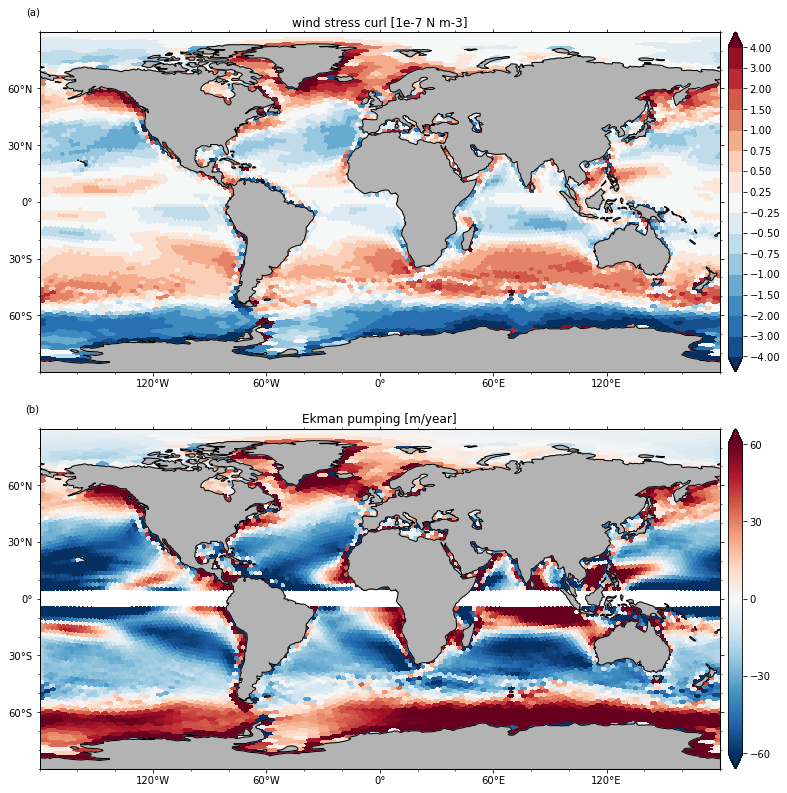

In [18]:
ccrs_proj = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(1,2, asp=0.5, projection=ccrs_proj, fig_size_fac=3, sharex=False)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, curl_taui/1e-7, ax=ax, cax=cax, clim=4, clevs=[-4,-3,-2,-1.5,-1.,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.,1.5,2,3,4], projection=ccrs.PlateCarree())
pyic.plot_settings(ax, template='global', land_facecolor='0.7')
ax.set_title('wind stress curl [1e-7 N m-3]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, w_eki*86400*365, ax=ax, cax=cax, clim=60, projection=ccrs.PlateCarree())
pyic.plot_settings(ax, template='global', land_facecolor='0.7')
ax.set_title('Ekman pumping [m/year]')

## Arctic plot

Text(0.5, 1.0, 'Ekman pumping [m/year]')

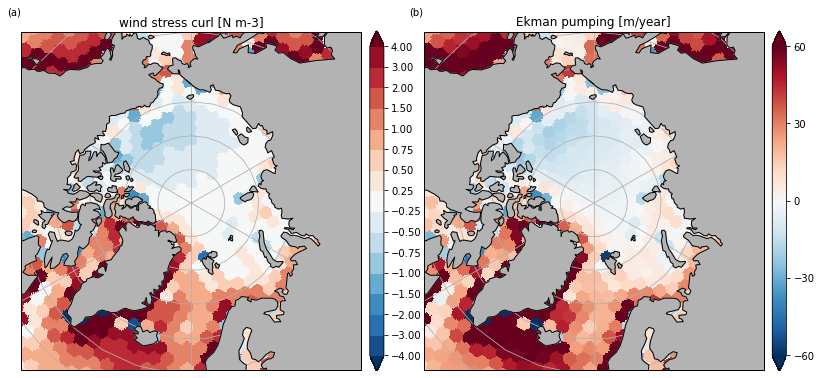

In [19]:
# --- NorthPolarStereo projection
ccrs_proj = ccrs.NorthPolarStereo()
hca, hcb = pyic.arrange_axes(2,1, asp=1.0, projection=ccrs_proj, fig_size_fac=3,
                             sharex=True, sharey=True)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, curl_taui/1e-7, ax=ax, cax=cax, clim=4, clevs=[-4,-3,-2,-1.5,-1.,-0.75,-0.5,-0.25,0.25,0.5,0.75,1.,1.5,2,3,4], projection=ccrs.PlateCarree())
pyic.plot_settings(ax=ax, xlim=[-180,180], ylim=[60,90], do_xyticks=False, do_xyminorticks=False, do_gridlines=True, land_facecolor='0.7')
ax.set_title('wind stress curl [N m-3]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, w_eki*86400*365, ax=ax, cax=cax, clim=60, projection=ccrs.PlateCarree())
pyic.plot_settings(ax=ax, xlim=[-180,180], ylim=[60,90], do_xyticks=False, do_xyminorticks=False, do_gridlines=True, land_facecolor='0.7')
ax.set_title('Ekman pumping [m/year]')